In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

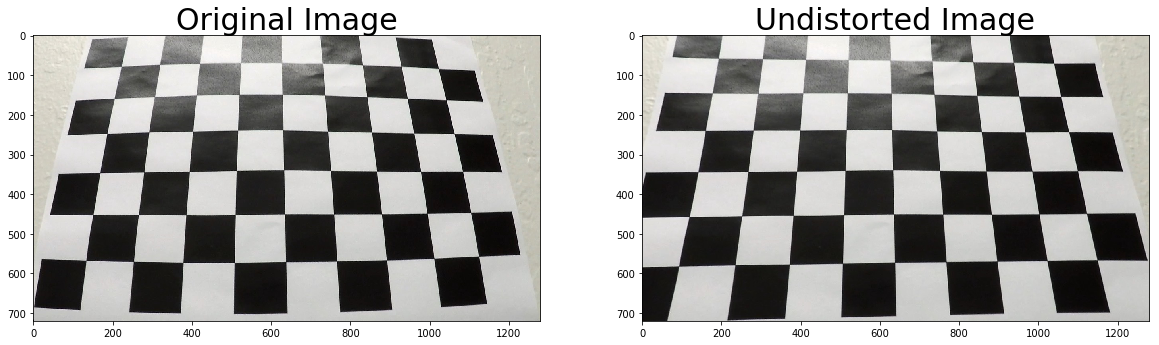

In [2]:
#Mohammad Azam Javed - 10/10/17
#Disclaimer: a lot of this code was given to us as part of the Course Content 
#in the Udacity Curriculum

import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

%matplotlib inline

# Test undistortion on an image
img = plt.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imsave('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
%matplotlib inline

imagecount = 0
prev_binary_warped_img = [np.array([False])]
prev_left_lane_inds = [np.array([False])]
prev_right_lane_inds = [np.array([False])]
prev_left_fit = [np.array([False])]
prev_right_fit = [np.array([False])]
total_avg_left_fit = [np.array([False])]
total_avg_right_fit = [np.array([False])]

#avg_right_lane_inds = [np.array([False])]
#avg_leftx = [np.array([False])]
#avg_lefty = [np.array([False])]
#avg_rightx = [np.array([False])]
#avg_righty = [np.array([False])]
#avg_left_fit = [np.array([False])]
#avg_right_fit = [np.array([False])]

dist_pickle = pickle.load(open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

#class Line():
#    def __init__(self):
#        # was the line detected in the last iteration?
#        self.detected = False  
#        # x values of the last n fits of the line
#        self.recent_xfitted = [] 
#        self.lane_width_avg = []
#        #average x values of the fitted line over the last n iterations
#        self.bestx = None     
#        #polynomial coefficients averaged over the last n iterations
#        self.best_fit = None  
#        #polynomial coefficients for the most recent fit
#        self.current_fit = [np.array([False])]  
#        #radius of curvature of the line in some units
#        self.radius_of_curvature = None 
#        #distance in meters of vehicle center from the line
#        self.line_base_pos = None 
#        #difference in fit coefficients between last and new fits
#        self.diffs = np.array([0,0,0], dtype='float') 
#        #x values for detected line pixels
#        self.allx = None  
#        #y values for detected line pixels
#        self.ally = None
#Left_Lane = Line()
#Right_Lane = Line()

def processimage(img, binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, total_avg_left_fit, nonzeroy, nonzerox, margin, Minv, lane_wid_up, lane_wid_dwn):
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    centerpos = binary_warped.shape[1]/2
    lane_center = (right_fitx[719] + left_fitx[719])/2
    center_offset_pixels = abs(centerpos - lane_center)
    
    y_eval = np.max(ploty)
    
    #Offset Calculation
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    #print(len(ploty),'y')
    #print(len(left_fitx),'x')

    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    #print(int((left_curverad+right_curverad)/2.0+0.5),'avg')
    # Example values: 632.1 m    626.2 m
    curvatureavg = int(left_curverad+right_curverad)/2.0+0.5
    offsetval = (center_offset_pixels*xm_per_pix)*1.00
    #print(round(offsetval,3),'offset')
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,0,255))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0,255))
    drawinglines = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    #font = cv2.FONT_HERSHEY_SIMPLEX
    
    #cv2.putText(drawinglines,'Left Lane Inds = '+str(len(left_lane_inds)),(100,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(drawinglines,'Right Lane Inds = '+str(len(right_lane_inds)),(100,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(drawinglines,'Total Left Lane Inds = '+str((total_avg_left_fit)),(100,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(drawinglines,'Left Line X Pix  = '+str(len(leftx)),(100,200), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(drawinglines,'Left Line y Pix= '+str(len(lefty)),(100,250), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(drawinglines,'Right Line x Pix  = '+str(len(rightx)),(100,300), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(drawinglines,'Right Line y Pix= '+str(len(righty)),(100,350), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(drawinglines,'lane width up  = '+str(lane_wid_up),(100,400), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(drawinglines,'lane width dwn = '+str(lane_wid_dwn),(100,450), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(drawinglines,'Left Radius = '+str(left_curverad),(100,500), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(drawinglines,'Right Radius = '+str(right_curverad),(100,550), font, 1,(255,255,255),2,cv2.LINE_AA)
    drawout = 'outputvids/drawoutfinal'+str(imagecount)+'.jpg'
    plt.imsave(drawout,drawinglines)
    cv2.waitKey(500)   
    
    #lane draw 
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    #print('len left fit x', len(left_fitx), 'ploty', len(ploty))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (137,187,255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    #font = cv2.FONT_HERSHEY_SIMPLEX
    
    #cv2.putText(result,'Left Lane Inds = '+str(len(left_lane_inds)),(100,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Right Lane Inds = '+str(len(right_lane_inds)),(100,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Total Left Lane Inds = '+str((total_avg_left_fit)),(100,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Left Line X Pix  = '+str(len(leftx)),(100,200), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Left Line y Pix= '+str(len(lefty)),(100,250), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Right Line x Pix  = '+str(len(rightx)),(100,300), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Right Line y Pix= '+str(len(righty)),(100,350), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'lane width up  = '+str(lane_wid_up),(100,400), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'lane width dwn = '+str(lane_wid_dwn),(100,450), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Left Radius = '+str(left_curverad),(100,500), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Right Radius = '+str(right_curverad),(100,550), font, 1,(255,255,255),2,cv2.LINE_AA)
    lineout = 'outputvids/finalstuffs'+str(imagecount)+'.jpg'
    plt.imsave(lineout,result)
    cv2.waitKey(500)
    #plt.figure()
    #plt.imshow(result)    
    
    return result, curvatureavg, offsetval
    #return drawinglines, ploty, left_fitx, right_fitx, curvatureavg, offsetval
    
def pipeline(img, s_thresh=(0, 255), sx_thresh=(200, 255)):
    img = np.copy(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    s_channel = hls[:,:,2] #for other yellow lane situations
    l_channel = hls[:,:,1]
    #S_hsv = hsv_image[:,:,1] #for shadows
    #V = hsv_image[:,:,2]
    R = img[:,:,0] #for yellow line
    G = img[:,:,1]
    thresh = (190, 255)
    #Vthresh = (200, 255)
    #S_thresh = (200, 255)
    R_binary = np.zeros_like(R)
    G_binary = np.zeros_like(G)
    #S_HSV_binary = np.zeros_like(S_hsv)
    #V_binary = np.zeros_like(V)
    #R and G threshold application
    R_binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    G_binary[(G > thresh[0]) & (G <= thresh[1])] = 1
    #S and V threshold application
    #S_HSV_binary[(S_hsv > S_thresh[0]) & (S_hsv <= S_thresh[1])] = 1
    #V_binary[(V > Vthresh[0]) & (V <= Vthresh[1])] = 1
    # S Threshold color channel
    s_thresh_min = 100
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    # Adding L channel to avoid dark shadows getting detected as lines 
    l_thresh_min = 100
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    #Combine the hresholds
    combined_binary = np.zeros_like(R_binary)
    combined_binary[((R_binary == 1) | (G_binary == 1)) &
                    ((l_binary == 1) | (s_binary == 1)) &
                    ((l_binary == 1) | (R_binary == 1)) &
                    ((s_binary == 1) | (R_binary == 1)) &
                    ((l_binary == 1) | (G_binary == 1)) &
                    ((s_binary == 1) | (G_binary == 1))]=1
                    #((R_binary == 1) | (V_binary == 1)) &
                    #((G_binary == 1) | (V_binary == 1)) &
                    #((l_binary == 1) | (V_binary == 1)) &
                    #((S_HSV_binary == 1) | (V_binary == 1))]=1

    binout = 'outputvids/binout'+str(imagecount)+'.jpg'
    plt.imsave(binout,combined_binary)
    cv2.waitKey(500)
    #plt.figure()
    #plt.imshow(combined_binary)
    
    return combined_binary

def histogram_gen(img, binary_warped, Minv):
    global imagecount
    global prev_binary_warped_img
    global prev_left_lane_inds
    global prev_right_lane_inds
    global prev_left_fit     
    global prev_right_fit
    global total_avg_left_fit
    global total_avg_right_fit
    
    #print('img count',imagecount)
    #imgout = 'outputvids/imgoufinalt'+str(imagecount)+'.jpg'
    #plt.imsave(imgout,img)
    #cv2.waitKey(500)
    #plt.figure()
    #plt.imshow(binary_warped)
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.figure() ##important 
    #plt.plot(histogram)
    #plt.savefig('outputvids/histooutfinal'+str(imagecount)+'.jpg')
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    left_val = np.max(histogram[:midpoint])
    right_val = np.max(histogram[midpoint:])
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    #print('non zero y', nonzeroy)
    nonzerox = np.array(nonzero[1])
    #print('non zero x', nonzerox)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    #print('len left lane inds', len(left_lane_inds))
    right_lane_inds = np.concatenate(right_lane_inds)
    #print('len right lane inds', len(right_lane_inds))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    #print('left lane x', len(leftx))
    lefty = nonzeroy[left_lane_inds] 
    #print('left lane y', len(lefty))
    rightx = nonzerox[right_lane_inds]
    #print('right lane x', len(rightx))
    righty = nonzeroy[right_lane_inds] 
    #print('right lane y', len(righty))
    
    #curr_pixels_left = len(leftx)
    #curr_pixels_right = len(rightx)

    #left_delta = curr_pixels_left / (curr_pixels_left + prev_pixels_left)
    #right_delta = curr_pixels_right / (curr_pixels_right + prev_pixels_right)
    #print('left delta', left_delta)
    #print('right delta', right_delta)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    #print('left fit ', left_fit)
    right_fit = np.polyfit(righty, rightx, 2)
    #print('right fit ', right_fit)
    
    left_width_val1 = left_fit[0]*(300**2)+left_fit[1]*(300)+left_fit[2]
    right_width_val1 = right_fit[0]*(300**2)+right_fit[1]*(300)+right_fit[2]
    lane_wid_up = right_width_val1 - left_width_val1
    
    left_width_val2 = left_fit[0]*(600**2)+left_fit[1]*(600)+left_fit[2]
    right_width_val2 = right_fit[0]*(600**2)+right_fit[1]*(600)+right_fit[2]
    lane_wid_dwn = right_width_val2 - left_width_val2
    
    #print('lane width up ', lane_wid_up)
    #print('lane width dwn ', lane_wid_dwn)
    
    #Left_Lane.lane_width_avg.append(lane_wid)
    
    confidence_left = []
    confidence_right = []
    
    #if left_fit[0] > 0 and prev_left_fit[0] < 0:
    #    print('left lane adjusted - before:',left_fit,'after:',prev_left_fit)
    #    left_fit = prev_left_fit
    #    #left_lane_inds = prev_left_lane_inds
    #elif left_fit[0] < 0 and prev_left_fit[0] > 0:
    #    print('left lane adjusted - before:',left_fit,'after:',prev_left_fit)
    #    left_fit = prev_left_fit
    #    #left_lane_inds = prev_left_lane_inds

    #if right_fit[0] > 0 and prev_right_fit[0] < 0:
    #    print('rightt lane adjusted - before:',right_fit,'after:',prev_right_fit)
    #    right_fit = prev_right_fit
    #    #right_lane_inds = prev_right_lane_inds
    #elif right_fit[0] < 0 and prev_right_fit[0] > 0:
    #    print('rightt lane adjusted - before:',right_fit,'after:',prev_right_fit)
    #    right_fit = prev_right_fit
        #right_lane_inds = prev_right_lane_inds
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    centerpos = binary_warped.shape[1]/2
    lane_center = (right_fitx[719] + left_fitx[719])/2
    center_offset_pixels = abs(centerpos - lane_center)
    
    y_eval = np.max(ploty)
    
    #Offset Calculation
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    #print(len(ploty),'y')
    #print(len(left_fitx),'x')

    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    #print(int((left_curverad+right_curverad)/2.0+0.5),'avg')
    # Example values: 632.1 m    626.2 m
    curvatureavg = int(left_curverad+right_curverad)/2.0+0.5
    offsetval = (center_offset_pixels*xm_per_pix)*1.00
    #print(round(offsetval,3),'offset')
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,0,255))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0,255))
    drawinglines = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    #font = cv2.FONT_HERSHEY_SIMPLEX
    
    #cv2.putText(drawinglines,'Left Radius = '+str(left_curverad),(100,450), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(drawinglines,'Right Radius = '+str(right_curverad),(100,500), font, 1,(255,255,255),2,cv2.LINE_AA)
    drawout = 'outputvids/drawoutfinal'+str(imagecount)+'.jpg'
    plt.imsave(drawout,drawinglines)
    cv2.waitKey(500)   
    
    if (len(leftx) < 2200 or len(rightx) < 2250) or (left_curverad < right_curverad and lane_wid_up > lane_wid_dwn) :
        #do this if the image is a failure
        
        left_lane_inds = prev_left_lane_inds
        right_lane_inds = prev_right_lane_inds
        left_fit = total_avg_left_fit
        right_fit = total_avg_right_fit
        nonzero = prev_binary_warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        result, curvatureavg, offsetval = processimage(img, prev_binary_warped_img, left_fit, right_fit, left_lane_inds, right_lane_inds, total_avg_left_fit, nonzeroy, nonzerox, margin, Minv, lane_wid_up, lane_wid_dwn)
        #print('total running avg left fit', total_avg_left_fit)
        #print('total running avg left fit', total_avg_right_fit)
        
        return result, curvatureavg, offsetval, lane_wid_up, lane_wid_dwn
    else:
        #use the image
        #update the weighted avg's 
        #cur_avg_left_lane_inds = int(sum(left_lane_inds) / len(left_lane_inds))
        #print('current avg left lane inds', cur_avg_left_lane_inds)
        prev_left_fit = left_fit
        prev_right_fit = right_fit
        
        prev_left_lane_inds = left_lane_inds
        prev_right_lane_inds = right_lane_inds
        
        prev_binary_warped_img = binary_warped
        #if len(prev_binary_warped_img) < 2:
        #    #indeces = indeces + 1
        #    prev_left_fit.append(left_fit) #add a left fit to the buffer
        #    prev_right_fit.append(right_fit) #add a left fit to the buffer
        #else: #buffer is 10 so need to remove one 
        #    prev_binary_warped_img.pop(0)
        #    prev_binary_warped_img.append(left_fit) #then add a new item to the buffer
            
        #    prev_right_fit.pop(0)
        #    prev_right_fit.append(right_fit) #then add a new item to the buffer
        if imagecount > 1 : 
            Left_newarray = []
            for x, y in zip(total_avg_left_fit,left_fit):
                #print('x',x,'y',y)
                avg = (x + y )/ 2
                #print('x + y / 2', avg)
                Left_newarray.append(avg)
            #print(Left_newarray)
            total_avg_left_fit = Left_newarray
            
            Right_newarray = []
            for x, y in zip(total_avg_right_fit,right_fit):
                #print('x',x,'y',y)
                avg = (x + y )/ 2
                #print('x + y / 2', avg)
                Right_newarray.append(avg)
            #print(Right_newarray)
            total_avg_right_fit = Right_newarray
        else:
            total_avg_left_fit = left_fit
            total_avg_right_fit = right_fit
            
        #print('total avg left fit', total_avg_left_fit)
        #print('total avg right fit', total_avg_right_fit)
        #return this image
    
    #lane draw 
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    #print('len left fit x', len(left_fitx), 'ploty', len(ploty))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (137,187,255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    #font = cv2.FONT_HERSHEY_SIMPLEX
    
    #cv2.putText(result,'Left Lane Inds = '+str(len(left_lane_inds)),(100,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Right Lane Inds = '+str(len(right_lane_inds)),(100,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Total Left Lane Inds = '+str((total_avg_left_fit)),(100,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Left Line X Pix  = '+str(len(leftx)),(100,200), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Left Line y Pix= '+str(len(lefty)),(100,250), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Right Line x Pix  = '+str(len(rightx)),(100,300), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Right Line y Pix= '+str(len(righty)),(100,350), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'lane width up  = '+str(lane_wid_up),(100,400), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'lane width dwn = '+str(lane_wid_dwn),(100,450), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Left Radius = '+str(left_curverad),(100,500), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(result,'Right Radius = '+str(right_curverad),(100,550), font, 1,(255,255,255),2,cv2.LINE_AA)
                
    lineout = 'outputvids/finalstuffs'+str(imagecount)+'.jpg'
    plt.imsave(lineout,result)
    cv2.waitKey(500)
    #plt.figure()
    #plt.imshow(result)    
    
    return result, curvatureavg, offsetval, lane_wid_up, lane_wid_dwn

def warp(img):
    global imagecount 
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    origimgout = 'outputvids/origfinal'+str(imagecount)+'.jpg'
    plt.imsave(origimgout,img)
    cv2.waitKey(500)
    #plt.figure()
    #plt.imshow(img)
    
    imagecount = imagecount + 1
    
    img_size = (img.shape[1], img.shape[0])
    #print(img_size)
    yoffset=470
    src = np.float32(
        [[180,img.shape[0]],
         [575,yoffset],
         [700,yoffset],
         [1100,img.shape[0]]])
   
    dst = np.float32(
        [[390, img.shape[0]],
         [430, 0],
         [920, 0],
         [990, img.shape[0]]])
    
    binary_img = pipeline(img, s_thresh=(90, 255), sx_thresh=(20, 100))
    binaryimgout = 'outputvids/binaryoutfinal'+str(imagecount)+'.jpg'
    plt.imsave(binaryimgout,binary_img)
    #plt.figure()
    #plt.imshow(binary_img)
    cv2.waitKey(500)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(binary_img, M, img_size, flags=cv2.INTER_LINEAR)
    warpedout = 'outputvids/warpoutfinal'+str(imagecount)+'.jpg'
    plt.imsave(warpedout,warped)
    cv2.waitKey(500)
    #plt.figure()
    #plt.imshow(warped)
    font = cv2.FONT_HERSHEY_SIMPLEX
    output,curve,offset,lane_wid_up,lane_wid_dwn = histogram_gen(img, warped, Minv)
    cv2.putText(output,'Radius of Curvature = '+str(curve),(100,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(output,'Offset = '+str(offset),(100,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(output,'Lane Width Top = '+str(lane_wid_up),(100,200), font, 1,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(output,'Lane Width Top = '+str(lane_wid_dwn),(100,250), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    outputresult = 'outputvids/finalstuff'+str(imagecount)+'.jpg'
    plt.imsave(outputresult,output)
    #plt.figure()
    #plt.imshow(output)
    cv2.waitKey(500)
    
    #print('max',max(Left_Lane.lane_width_avg))
    
    #cv2.putText(output,'Radius of Curvature = '+str(curve),(100,600), font, 2,(255,255,255),2,cv2.LINE_AA)
    #cv2.putText(output,'Offset = '+str("{0:.3f}".format(offset)),(100,700), font, 2,(255,255,255),2,cv2.LINE_AA)
    
    return output

white_output = 'outputvids/project4out.mp4'
clip1 = VideoFileClip("calibration_wide/project_video.mp4")#.subclip(21,26)
white_clip = clip1.fl_image(warp) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

#imagename = 'test3.jpg'
#image = mpimg.imread('calibration_wide/'+imagename)
#output = warp(image)
#plt.figure()
#plt.imshow(output)


[MoviePy] >>>> Building video outputvids/project4out.mp4
[MoviePy] Writing video outputvids/project4out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [24:18<00:01,  1.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: outputvids/project4out.mp4 

Wall time: 24min 18s


In [1]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

NameError: name 'HTML' is not defined